In [207]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
from itertools import combinations,product
from pykalman import KalmanFilter
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')

period_candi = [(3,1),(6,1),(12,1),(24,12)]

formation_train = {}
for cnd in period_candi:

    train_window_width = cnd[0]
    test_window_width = cnd[1]

    train_period = []
    test_period = []
    for i in range(len(monthly)- train_window_width-test_window_width):
        train_start_date = monthly[i]
        train_end_date = monthly[i+train_window_width]
        test_end_date = monthly[i+train_window_width+test_window_width]

        if test_end_date.year < 2017:

            train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
        
        elif test_end_date.year >=2017:

            test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
    formation_train[cnd] = (train_period, test_period)

performance_test = formation_train[(24,12)][1][48:60]
performance_test


[('2018-01-01', '2020-01-01', '2021-01-01'),
 ('2018-02-01', '2020-02-01', '2021-02-01'),
 ('2018-03-01', '2020-03-01', '2021-03-01'),
 ('2018-04-01', '2020-04-01', '2021-04-01'),
 ('2018-05-01', '2020-05-01', '2021-05-01'),
 ('2018-06-01', '2020-06-01', '2021-06-01'),
 ('2018-07-01', '2020-07-01', '2021-07-01'),
 ('2018-08-01', '2020-08-01', '2021-08-01'),
 ('2018-09-01', '2020-09-01', '2021-09-01'),
 ('2018-10-01', '2020-10-01', '2021-10-01'),
 ('2018-11-01', '2020-11-01', '2021-11-01'),
 ('2018-12-01', '2020-12-01', '2021-12-01')]

In [836]:
def get_mdd(x):
    x = x.fillna(0)
    peak_high = x.fillna(0).cummax()
    mdd = -(1 - x/peak_high)
    return mdd.fillna(0) * 100

def pair_list_sort (pair_data, price_df, idx = 0):

    df_formation = price_df.loc[performance_test[idx][0]:performance_test[idx][1]]
    df_trading = price_df.loc[performance_test[idx][1]:performance_test[idx][2]]
    pair_list = []
    for x in pair_data[idx][0]:
        if x == []:
            pass
        else:
            for pair in x:
                pair_list.append(pair)
    return pair_list, df_formation, df_trading

def KalmanFilterAverage(x):

    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)

    state_means, state_covs = kf.filter(y.values)
    return state_means, state_covs

def half_life(spread):
    
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 2
    return halflife

def backtest(df_form, df_trade, pair, tr=0):

    s1 = pair[0]
    s2 = pair[1]

    x = df_trade.loc[:, s1]
    y = df_trade.loc[:, s2]
    x_f = df_form.loc[:, s1]
    y_f = df_form.loc[:, s2]

    df1 = np.log(pd.DataFrame({'y':y,'x':x}))
    df_f = np.log(pd.DataFrame({'y':y_f,'x':x_f}))

    state_means, _ = KalmanFilterRegression(KalmanFilterAverage(df_f['x']), KalmanFilterAverage(df_f['y']))

    hedge_ratio_arr = list(state_means[:,0])

    for idx in df1.index:
        tmp = pd.concat([df_f, df1.loc[:idx]])
        state_means, _ = KalmanFilterRegression(KalmanFilterAverage(tmp['x']), KalmanFilterAverage(tmp['y']))
        hedge_ratio_arr.append(state_means[:,0][-1])   

    hedge_ratio_arr = np.array(hedge_ratio_arr)

    df1['hr'] = - hedge_ratio_arr[len(df_f):]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    halflife = half_life(df1['spread'])

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 

    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1))
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR, df1


In [568]:
# def getError(theta, state_covs, latest_prices):

#     vt = 1e-3
#     P = np.zeros((2, 2))
#     R = state_covs
#     F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
#     y = latest_prices[1]
#     yhat = F.dot(theta)
#     et = y - yhat
#     Qt = F.dot(R).dot(F.T) + vt
#     sqrt_Qt = np.sqrt(Qt)
#     return et, sqrt_Qt

# def getUpdate(theta, state_covs, latest_prices):
#     delta = 1e-4
#     wt = delta / (1 - delta) * np.eye(2)
#     vt = 1e-3

#     P = np.zeros((2, 2))
#     R = state_covs

#     F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
#     y = latest_prices[1]
#     yhat = F.dot(theta)
#     et = y - yhat
#     Qt = F.dot(R).dot(F.T) + vt
#     sqrt_Qt = np.sqrt(Qt)
#     At = R.dot(F.T) / Qt
#     new_theta = theta + At.flatten() * et
#     C = R - At * F.dot(R)
#     new_R = C + wt
    
#     return new_theta, new_R


# def backtest2(df_form, df_trade, pair, tr=0.0025):

#     s1 = pair[0]
#     s2 = pair[1]

#     x = df_trade.loc[:, s1]
#     y = df_trade.loc[:, s2]
#     x_f = df_form.loc[:, s1]
#     y_f = df_form.loc[:, s2]

#     # df1 = pd.DataFrame({'y':y,'x':x})
#     # df_f = pd.DataFrame({'y':y_f,'x':x_f})

#     df_f = np.log(pd.DataFrame({'y':y_f,'x':x_f}))
#     df1 = np.log(pd.DataFrame({'y':y,'x':x}))

#     state_means, state_covs = KalmanFilterRegression(KalmanFilterAverage(df_f['x']), KalmanFilterAverage(df_f['y']))

#     state_means_new = []
#     state_means_new.append(state_means[-1])
#     state_covs_new = []
#     state_covs_new.append(state_covs[-1])
#     error_list = []
#     stdev_list = []

#     for num, idx in enumerate(df1.index):

#         # idx = df_t.index[0]
#         new_price_1 = df1.loc[idx, 'x']
#         new_price_2 = df1.loc[idx, 'y']

#         my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
#         my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

#         state_means_new.append(my_new_theta)
#         state_covs_new.append(my_new_R)
#         error_list.append(my_error)
#         stdev_list.append(my_stdev[0])

#     state_means_new = [x[0] for x in state_means_new]
#     state_means_new = np.array(state_means_new)

#     df1['hr'] =  state_means_new[1:]
#     df1['spread'] = df1.y - (df1.x * df1.hr)

#     halflife = half_life(df1['spread'])
    
#     meanSpread = df1.spread.rolling(window=halflife).mean()
#     stdSpread = df1.spread.rolling(window=halflife).std()
#     df1['zScore'] = (df1.spread-meanSpread)/stdSpread

#     entryZscore = 2
#     exitZscore = 0

#     df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
#     df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
#     df1['num units long'] = np.nan 
#     df1.loc[df1['long entry'],'num units long'] = 1 
#     df1.loc[df1['long exit'],'num units long'] = 0 
#     df1['num units long'][0] = 0 
#     df1['num units long'] = df1['num units long'].fillna(method='pad') 

#     df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
#     df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
#     df1.loc[df1['short entry'],'num units short'] = -1
#     df1.loc[df1['short exit'],'num units short'] = 0
#     df1['num units short'][0] = 0
#     df1['num units short'] = df1['num units short'].fillna(method='pad')
#     df1['numUnits'] = df1['num units long'] + df1['num units short']
#     df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
#     df1['port rets'] = (df1['spread pct ch'] * (1-tr)) * df1['numUnits'].shift(1) * 100
#     df1['cum rets'] = df1['port rets'].cumsum()
#     df1['cum rets'] = df1['cum rets'] + 1

#     try:
#         sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
#     except ZeroDivisionError:
#         sharpe = 0.0

#     start_val = 1
#     end_val = df1['cum rets'].iat[-1]
#     start_date = df1.iloc[0].name
#     end_date = df1.iloc[-1].name
#     days = (end_date - start_date).days
#     CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
#     df1[s1+ " "+s2] = df1['cum rets'] 

#     return df1[s1+" "+s2], sharpe, CAGR, df1


In [837]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
price_df = price_df.pivot(columns='tic', values='Adj Close', index='Date')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

pair_data = pd.read_pickle('2020~2021_pair_reg.pkl')


pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 2)

pair = pair_list[2]

reg, sharpe, CAGR, reg_df = backtest(df_form, df_trade, pair, 0.25)

reg_df

y         x        hr    spread    zScore  long entry  \
Date                                                                       
2020-03-02  4.916892  4.912721 -0.838492  0.797617       NaN       False   
2020-03-03  4.888564  4.883021 -0.838416  0.794563       NaN       False   
2020-03-04  4.929721  4.924776 -0.838345  0.801061       NaN       False   
2020-03-05  4.895972  4.891484 -0.838268  0.795598       NaN       False   
2020-03-06  4.878698  4.873314 -0.838183  0.793970       NaN       False   
...              ...       ...       ...       ...       ...         ...   
2021-02-23  5.181700  5.182411 -0.844436  0.805485 -1.950383       False   
2021-02-24  5.191141  5.192555 -0.844465  0.806212 -1.212558       False   
2021-02-25  5.166506  5.166999 -0.844484  0.803059 -2.002471        True   
2021-02-26  5.161763  5.162927 -0.844493  0.801708 -1.802610       False   
2021-03-01  5.186295  5.186841 -0.844502  0.805997 -0.186557       False   

            long exit  num units long  short entry  short exit  \
Date                                                             
2020-03-02      False             0.0        False       False   
2020-03-03      False             0.0        False       False   
2020-03-04      False             0.0        False       False   
2020-03-05      False             0.0        False       False   
2020-03-06      False             0.0        False       False   
...               ...             ...          ...         ...   
2021-02-23      False             1.0        False       False   
2021-02-24      False             1.0        False       False   
2021-02-25      False             1.0        False       False   
2021-02-26      False             1.0        False       False   
2021-03-01      False             1.0        False       False   

            num units short  numUnits  spread pct ch  port rets  cum rets  \
Date                                                                        
2020-03-02              0.0       0.0            NaN        NaN       NaN   
2020-03-03              0.0       0.0      -0.003054  -0.000000  1.000000   
2020-03-04              0.0       0.0       0.006498   0.000000  1.000000   
2020-03-05              0.0       0.0      -0.005463  -0.000000  1.000000   
2020-03-06              0.0       0.0      -0.001629  -0.000000  1.000000   
...                     ...       ...            ...        ...       ...   
2021-02-23              0.0       1.0      -0.000894  -0.000671  1.023322   
2021-02-24              0.0       1.0       0.000727   0.000545  1.023867   
2021-02-25              0.0       1.0      -0.003153  -0.002365  1.021503   
2021-02-26              0.0       1.0      -0.001351  -0.001013  1.020490   
2021-03-01              0.0       1.0       0.004288   0.003216  1.023706   

             VONE VV  
Date                  
2020-03-02       NaN  
2020-03-03  1.000000  
2020-03-04  1.000000  
2020-03-05  1.000000  
2020-03-06  1.000000  
...              ...  
2021-02-23  1.023322  
2021-02-24  1.023867  
2021-02-25  1.021503  
2021-02-26  1.020490  
2021-03-01  1.023706  

[252 rows x 16 columns]

In [297]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
price_df = price_df.pivot(columns='tic', values='Adj Close', index='Date')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

pair_data = pd.read_pickle('2020~2021_pair_reg.pkl')


In [624]:
reg_sharpe_dict = {}
reg_df_dict = {}
reg_CAGR_dict = {}
reg_pair_cumret_dict = {}
reg_pair_dict = {}

for trial in tqdm(range(len(pair_data))):
#for trial in tqdm(range(1)):

    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)

    if pair_list == []:
        reg_sharpe_dict[trial] = []
        reg_df_dict[trial] = []
        reg_CAGR_dict[trial] = []
        reg_pair_cumret_dict[trial] = []
        reg_pair_dict[trial] = []

    else:
        reg_pair_list = []
        reg_sharpe_list = []
        reg_df_list = []
        reg_CAGR_list = []
        reg_pair_cumret_list = []

        for pair in pair_list:
            
            reg, sharpe, CAGR, reg_df = backtest(df_form, df_trade, pair)
            
            reg_pair_list.append(pair)
            reg_sharpe_list.append(sharpe)
            reg_df_list.append(reg_df)
            reg_CAGR_list.append(CAGR)
            reg_pair_cumret_list.append(reg)
        
        reg_pair_dict[trial]        = reg_pair_list
        reg_sharpe_dict[trial]      = reg_sharpe_list
        reg_df_dict[trial]          = reg_df_list
        reg_CAGR_dict[trial]        = reg_CAGR_list
        reg_pair_cumret_dict[trial] = reg_pair_cumret_list

100%|██████████| 12/12 [06:54<00:00, 34.53s/it]


In [625]:
reg_sharpe_dict

{0: [0.15976630489849758,
  -0.04490022970255716,
  0.872427339822604,
  -0.14496677625574092],
 1: [-0.08395416093227438,
  -0.16662441136552172,
  0.0,
  0.5156032639577681,
  0.5925133347975478,
  0.8044451786093345],
 2: [0.8407555830006616, 1.83790908909151, 1.700747308815373],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: []}

In [574]:
performance_test[2]

('2018-03-01', '2020-03-01', '2021-03-01')

In [870]:
start_date = performance_test[2][1]
end_date = performance_test[2][2]

name = reg_pair_dict[2][0]
plot = reg_df_dict[2][0]
sharpe = reg_sharpe_dict[2][0]
plot

y         x        hr    spread    zScore  long entry  \
Date                                                                       
2020-03-02  5.693747  5.690376 -0.856982  0.817197       NaN       False   
2020-03-03  5.664655  5.661326 -0.856898  0.813478       NaN       False   
2020-03-04  5.707663  5.702500 -0.856822  0.821635       NaN       False   
2020-03-05  5.672123  5.668693 -0.856742  0.815516       NaN       False   
2020-03-06  5.655325  5.652024 -0.856654  0.813498       NaN       False   
...              ...       ...       ...       ...       ...         ...   
2021-02-23  5.938616  5.934963 -0.861308  0.826787 -1.330478       False   
2021-02-24  5.949535  5.945921 -0.861338  0.828085 -0.195687       False   
2021-02-25  5.925261  5.921531 -0.861362  0.824681 -1.805908       False   
2021-02-26  5.920010  5.916365 -0.861378  0.823785 -1.585409       False   
2021-03-01  5.943976  5.940316 -0.861394  0.827024  0.317122       False   

            long exit  num units long  short entry  short exit  \
Date                                                             
2020-03-02      False             0.0        False       False   
2020-03-03      False             0.0        False       False   
2020-03-04      False             0.0        False       False   
2020-03-05      False             0.0        False       False   
2020-03-06      False             0.0        False       False   
...               ...             ...          ...         ...   
2021-02-23      False             1.0        False       False   
2021-02-24      False             1.0        False       False   
2021-02-25      False             1.0        False       False   
2021-02-26      False             1.0        False       False   
2021-03-01       True             0.0        False       False   

            num units short  numUnits  spread pct ch  port rets  cum rets  \
Date                                                                        
2020-03-02              0.0       0.0            NaN        NaN       NaN   
2020-03-03              0.0       0.0      -0.003720  -0.000000  1.000000   
2020-03-04              0.0       0.0       0.008157   0.000000  1.000000   
2020-03-05              0.0       0.0      -0.006119  -0.000000  1.000000   
2020-03-06              0.0       0.0      -0.002019  -0.000000  1.000000   
...                     ...       ...            ...        ...       ...   
2021-02-23              0.0       1.0      -0.000175  -0.000175  1.007155   
2021-02-24              0.0       1.0       0.001298   0.001298  1.008453   
2021-02-25              0.0       1.0      -0.003404  -0.003404  1.005049   
2021-02-26              0.0       1.0      -0.000895  -0.000895  1.004153   
2021-03-01              0.0       0.0       0.003238   0.003238  1.007391   

             SPY IVV  
Date                  
2020-03-02       NaN  
2020-03-03  1.000000  
2020-03-04  1.000000  
2020-03-05  1.000000  
2020-03-06  1.000000  
...              ...  
2021-02-23  1.007155  
2021-02-24  1.008453  
2021-02-25  1.005049  
2021-02-26  1.004153  
2021-03-01  1.007391  

[252 rows x 16 columns]

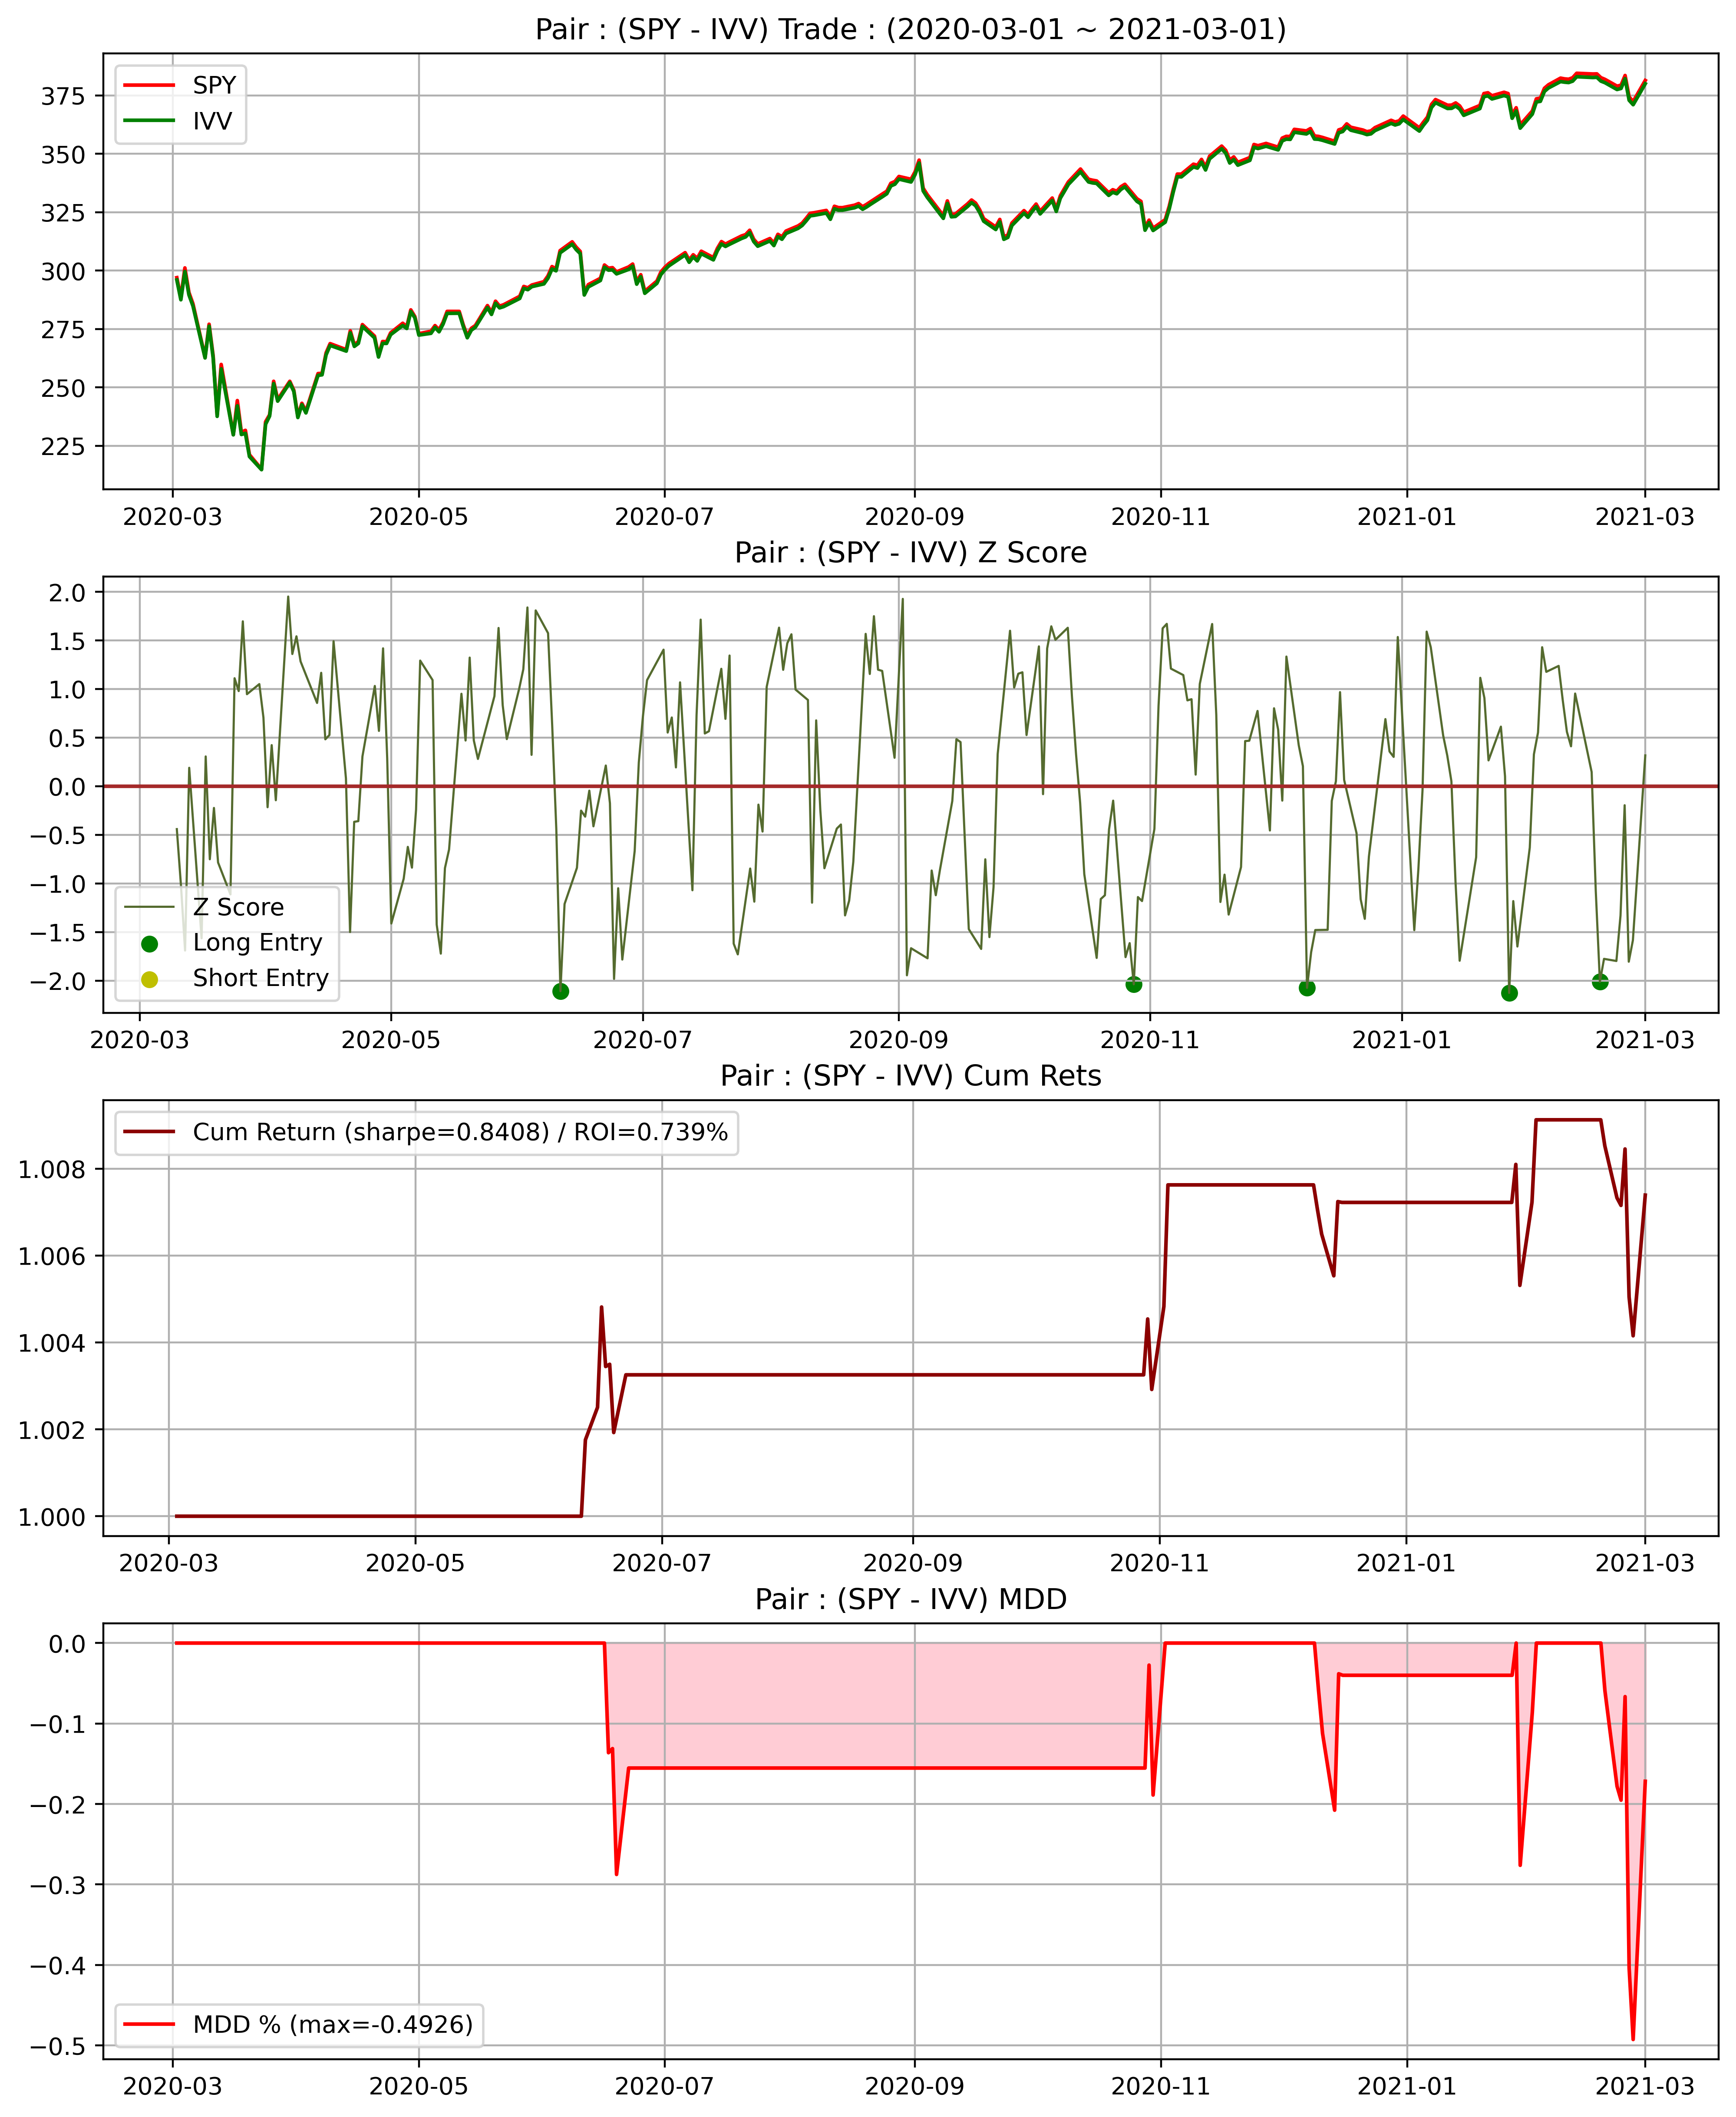

In [841]:
start_date = performance_test[2][1]
end_date = performance_test[2][2]

name = reg_pair_dict[2][0]
plot = reg_df_dict[2][0]
sharpe = reg_sharpe_dict[2][0]

plot_roi = np.round((plot[plot.columns[-1]][-1] - 1) * 100, 3)

plt.figure(figsize=(12,15), dpi=400)
plt.subplot(4,1,1)
plt.title(f'Pair : ({name[0]} - {name[1]}) Trade : ({start_date} ~ {end_date})')
plt.plot(np.exp(plot[plot.columns[0]]), label=name[0], color='red')
plt.plot(np.exp(plot[plot.columns[1]]), label=name[1], color='g')
plt.grid()
plt.legend()

# plt.subplot(5,1,2)
# plt.title(f'Pair : ({name[0]} - {name[1]}) Spread')
# plt.plot(plot['spread'], color='darkgreen')
# plt.grid()
# plt.legend()

plt.subplot(4,1,2)
plt.title(f'Pair : ({name[0]} - {name[1]}) Z Score')
plt.plot(plot[plot.columns[4]], label='Z Score', color='darkolivegreen', linewidth=0.9)
plt.scatter(plot.index, np.where(plot['long entry'] == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
#plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
#plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
# plt.scatter(plot.index, np.where(long_arr == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
# plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
# plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
# plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
plt.axhline(0, color='brown')
plt.grid()
plt.legend()


plt.subplot(4,1,3)
plt.title(f'Pair : ({name[0]} - {name[1]}) Cum Rets')
plt.plot(plot[plot.columns[-1]], label=f'Cum Return (sharpe={np.round(sharpe, 4)}) / ROI={plot_roi}%', color='darkred')
plt.legend()
plt.grid()

plt.subplot(4,1,4)
plt.title(f'Pair : ({name[0]} - {name[1]}) MDD')
plt.plot(get_mdd(plot[plot.columns[-1]]), label=f'MDD % (max={np.round(min(get_mdd(plot[plot.columns[-1]])), 4)})', color='r')
plt.fill_between(plot.index, get_mdd(plot[plot.columns[-1]]), color='pink', alpha=0.8)
plt.legend()
plt.grid()

#plt.plot(plot[plot.columns[-1]])

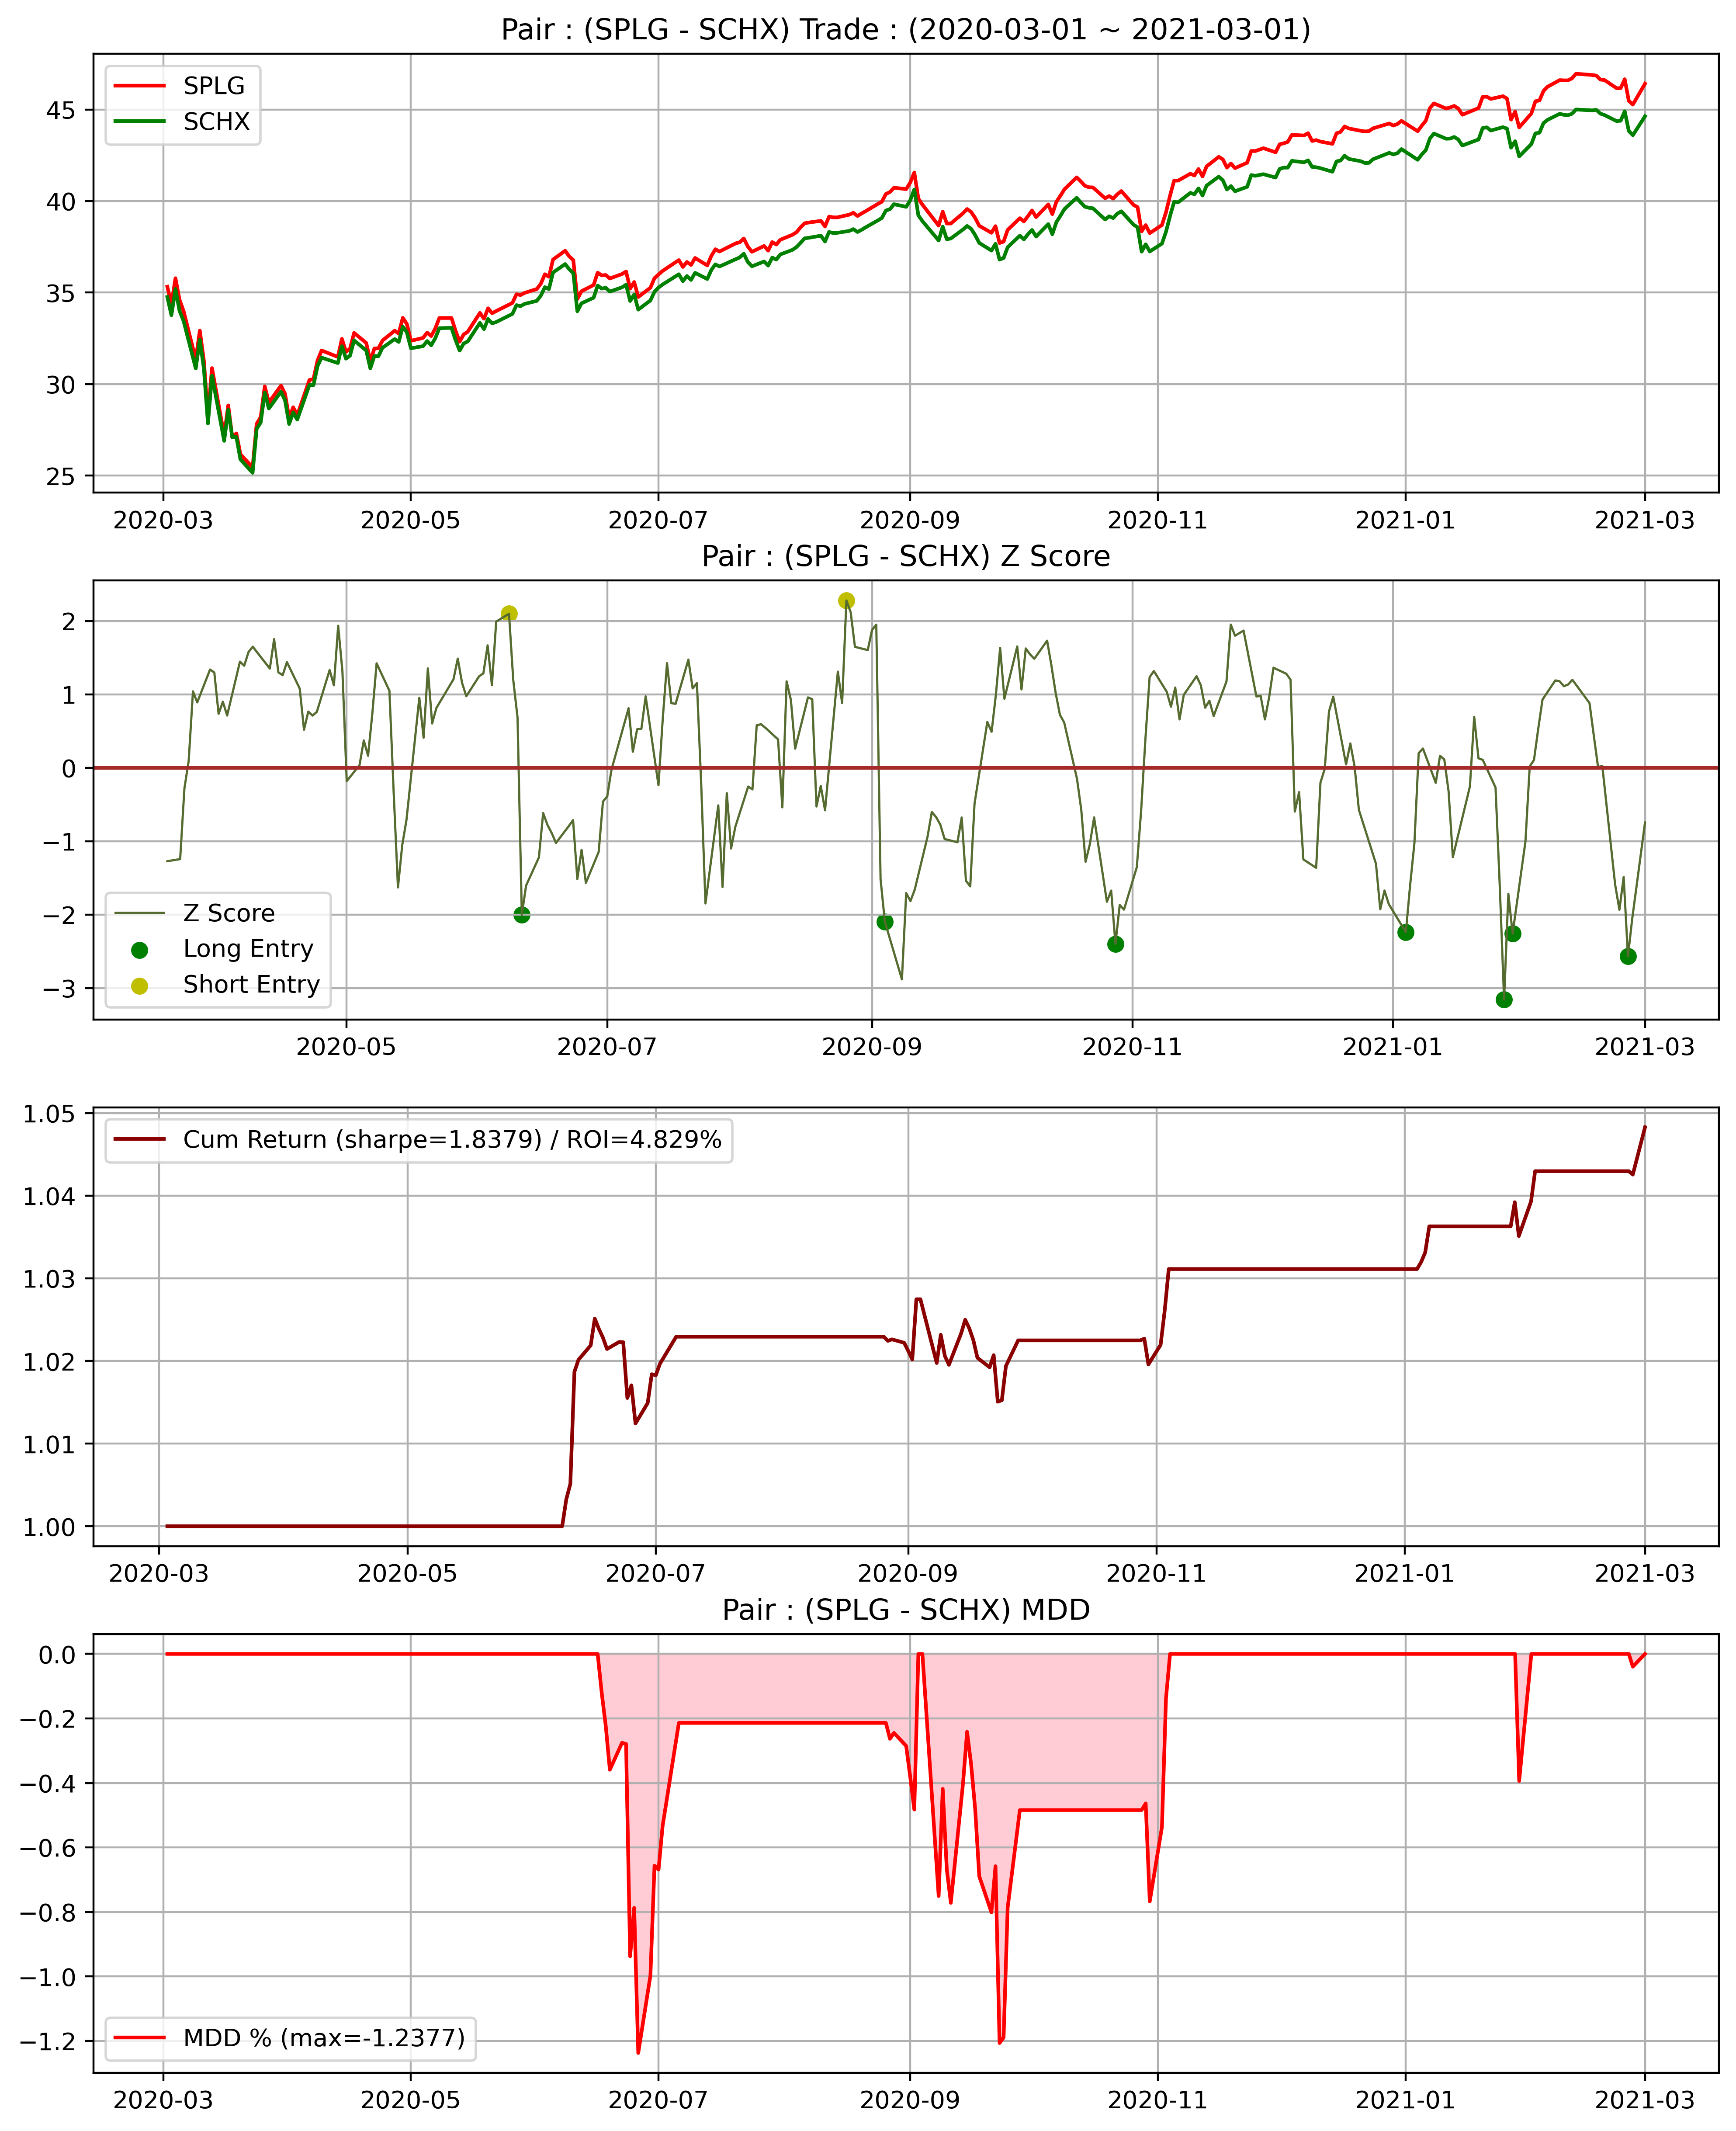

In [846]:
start_date = performance_test[2][1]
end_date = performance_test[2][2]

name = reg_pair_dict[2][1]
plot = reg_df_dict[2][1]
sharpe = reg_sharpe_dict[2][1]

plot_roi = np.round((plot[plot.columns[-1]][-1] - 1) * 100, 3)

plt.figure(figsize=(12,15), dpi=400)
plt.subplot(4,1,1)
plt.title(f'Pair : ({name[0]} - {name[1]}) Trade : ({start_date} ~ {end_date})')
plt.plot(np.exp(plot[plot.columns[0]]), label=name[0], color='red')
plt.plot(np.exp(plot[plot.columns[1]]), label=name[1], color='g')
plt.grid()
plt.legend()

# plt.subplot(5,1,2)
# plt.title(f'Pair : ({name[0]} - {name[1]}) Spread')
# plt.plot(plot['spread'], color='darkgreen')
# plt.grid()
# plt.legend()

plt.subplot(4,1,2)
plt.title(f'Pair : ({name[0]} - {name[1]}) Z Score')
plt.plot(plot[plot.columns[4]], label='Z Score', color='darkolivegreen', linewidth=0.9)
plt.scatter(plot.index, np.where(plot['long entry'] == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
#plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
#plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
# plt.scatter(plot.index, np.where(long_arr == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
# plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
# plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
# plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
plt.axhline(0, color='brown')
plt.grid()
plt.legend()


plt.subplot(4,1,3)
plt.plot(plot[plot.columns[-1]], label=f'Cum Return (sharpe={np.round(sharpe, 4)}) / ROI={plot_roi}%', color='darkred')
plt.legend()
plt.grid()

plt.subplot(4,1,4)
plt.title(f'Pair : ({name[0]} - {name[1]}) MDD')
plt.plot(get_mdd(plot[plot.columns[-1]]), label=f'MDD % (max={np.round(min(get_mdd(plot[plot.columns[-1]])), 4)})', color='r')
plt.fill_between(plot.index, get_mdd(plot[plot.columns[-1]]), color='pink', alpha=0.8)
plt.legend()
plt.grid()

#plt.plot(plot[plot.columns[-1]])

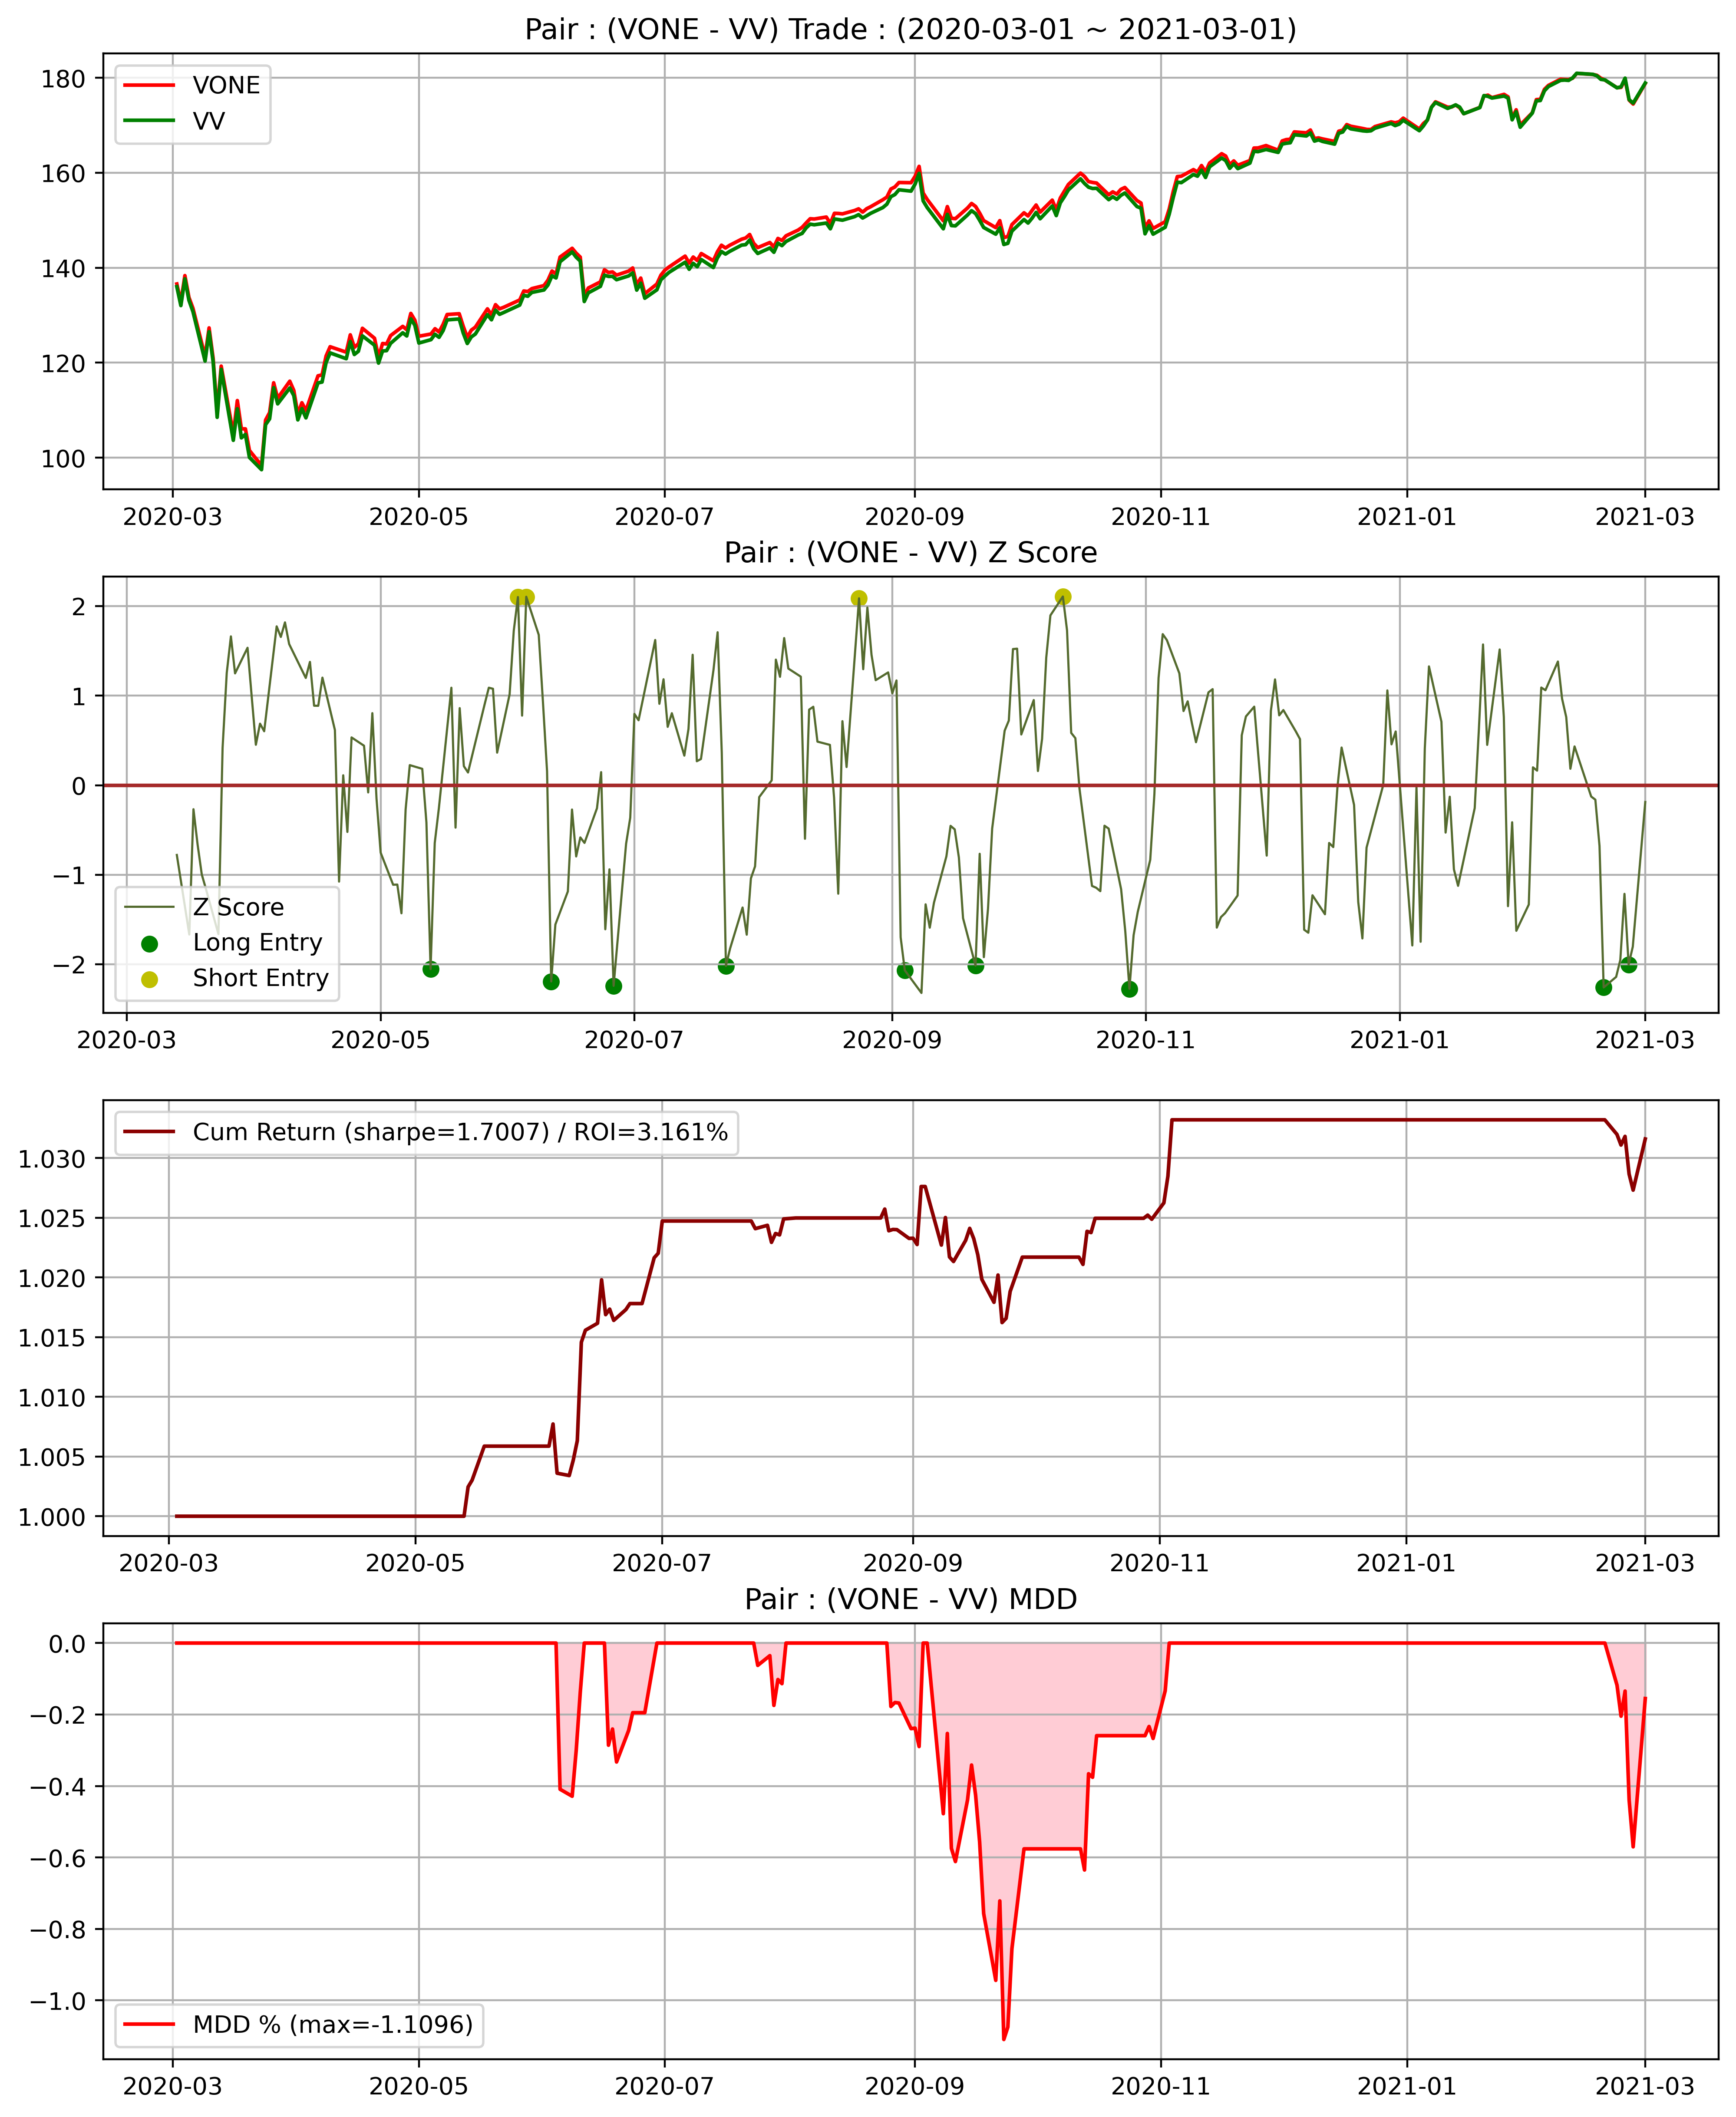

In [847]:
start_date = performance_test[2][1]
end_date = performance_test[2][2]

name = reg_pair_dict[2][2]
plot = reg_df_dict[2][2]
sharpe = reg_sharpe_dict[2][2]

plot_roi = np.round((plot[plot.columns[-1]][-1] - 1) * 100, 3)

plt.figure(figsize=(12,15), dpi=400)
plt.subplot(4,1,1)
plt.title(f'Pair : ({name[0]} - {name[1]}) Trade : ({start_date} ~ {end_date})')
plt.plot(np.exp(plot[plot.columns[0]]), label=name[0], color='red')
plt.plot(np.exp(plot[plot.columns[1]]), label=name[1], color='g')
plt.grid()
plt.legend()

# plt.subplot(5,1,2)
# plt.title(f'Pair : ({name[0]} - {name[1]}) Spread')
# plt.plot(plot['spread'], color='darkgreen')
# plt.grid()
# plt.legend()

plt.subplot(4,1,2)
plt.title(f'Pair : ({name[0]} - {name[1]}) Z Score')
plt.plot(plot[plot.columns[4]], label='Z Score', color='darkolivegreen', linewidth=0.9)
plt.scatter(plot.index, np.where(plot['long entry'] == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
#plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
#plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
# plt.scatter(plot.index, np.where(long_arr == True, plot['zScore'], np.NaN), color='g', label='Long Entry')
# plt.scatter(plot.index, np.where(plot['short entry'] == True, plot['zScore'], np.NaN), color='y', label='Short Entry')
# plt.scatter(plot.index, np.where(plot['long exit'] == True, plot['zScore'], np.NaN), color='g', marker='^', label='Long Exit')
# plt.scatter(plot.index, np.where(plot['short exit'] == True, plot['zScore'], np.NaN), color='y', marker='^', label='Short Entry')
plt.axhline(0, color='brown')
plt.grid()
plt.legend()


plt.subplot(4,1,3)
plt.plot(plot[plot.columns[-1]], label=f'Cum Return (sharpe={np.round(sharpe, 4)}) / ROI={plot_roi}%', color='darkred')
plt.legend()
plt.grid()

plt.subplot(4,1,4)
plt.title(f'Pair : ({name[0]} - {name[1]}) MDD')
plt.plot(get_mdd(plot[plot.columns[-1]]), label=f'MDD % (max={np.round(min(get_mdd(plot[plot.columns[-1]])), 4)})', color='r')
plt.fill_between(plot.index, get_mdd(plot[plot.columns[-1]]), color='pink', alpha=0.8)
plt.legend()
plt.grid()

#plt.plot(plot[plot.columns[-1]])

In [781]:
(trial_port[-1] - 1)/1 * 100

2.9096664977034115

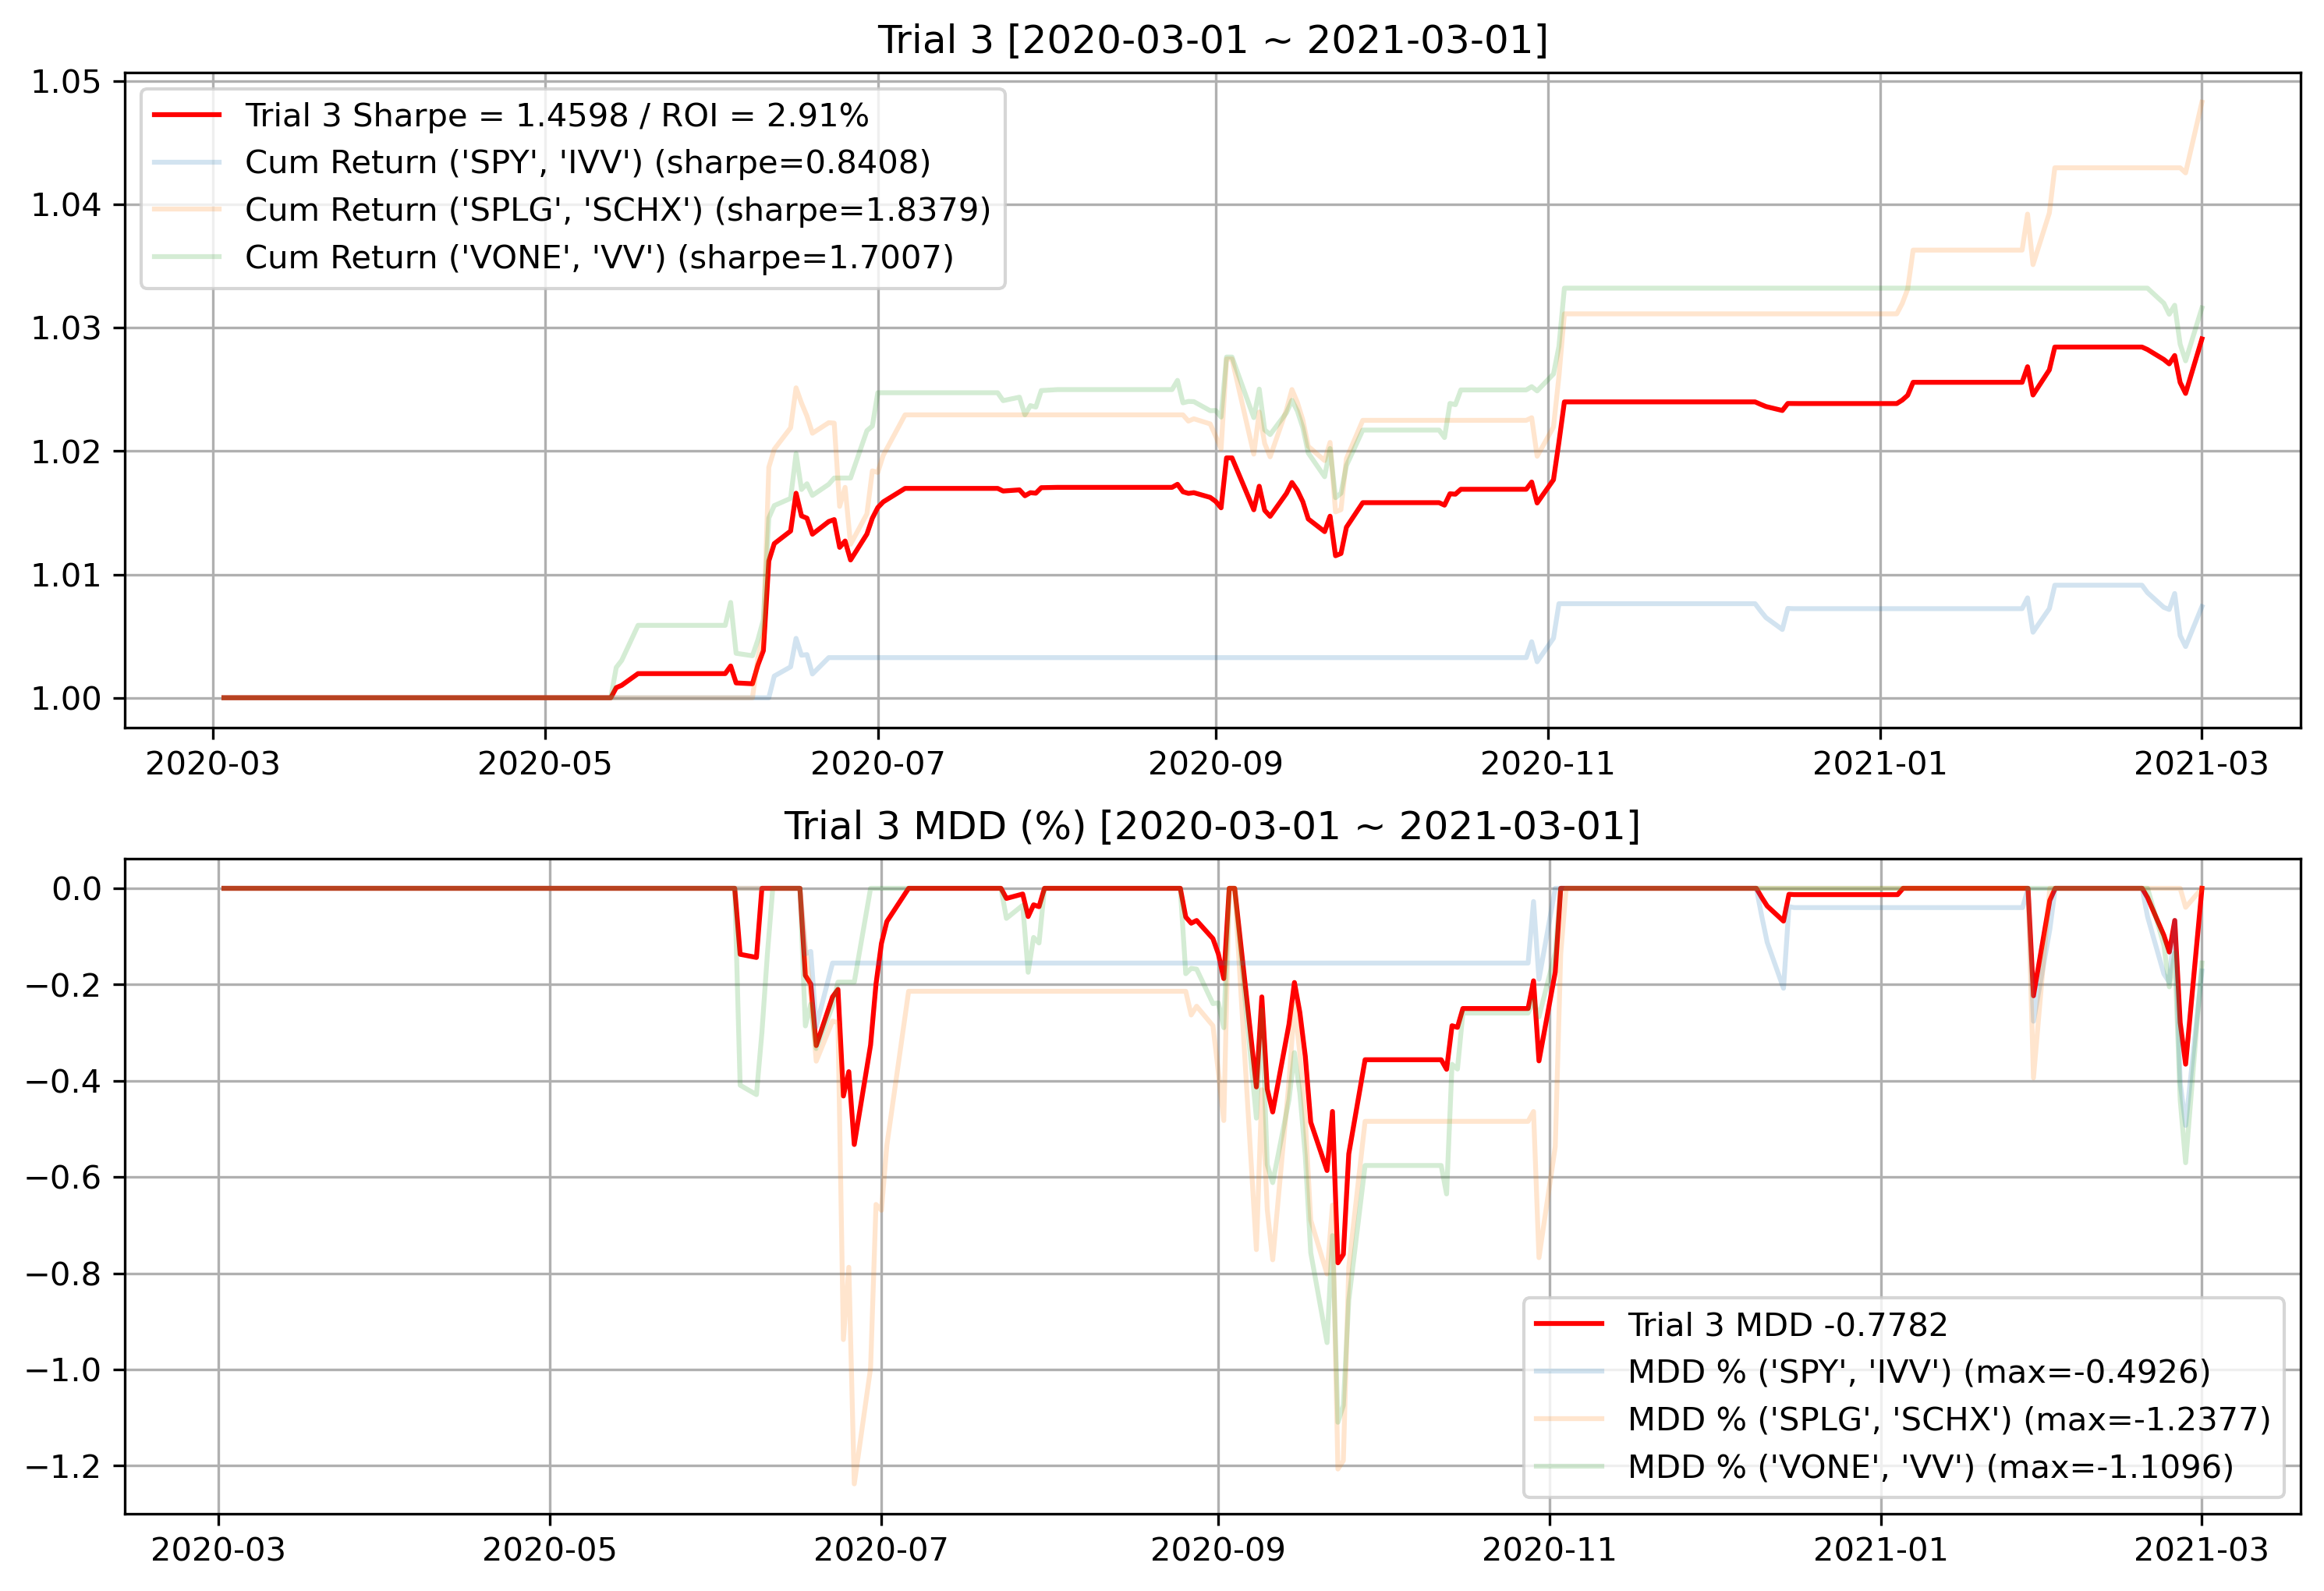

In [795]:
start_date = performance_test[2][1]
end_date = performance_test[2][2]

name = reg_pair_dict[2][0]
plot = reg_df_dict[2][0]
sharpe = reg_sharpe_dict[2][0]

name1 = reg_pair_dict[2][1]
plot1 = reg_df_dict[2][1]
sharpe1 = reg_sharpe_dict[2][1]

name2 = reg_pair_dict[2][2]
plot2 = reg_df_dict[2][2]
sharpe2 = reg_sharpe_dict[2][2]

trial_port = pd.concat([plot[plot.columns[-1]], plot1[plot1.columns[-1]], plot2[plot2.columns[-1]]], axis=1).mean(axis=1)
trial_roi = np.round((trial_port[-1] - 1)/1 * 100, 3)

plt.figure(figsize=(12,8), dpi=300)
plt.subplot(2,1,1)
plt.title(f'Trial 3 [{start_date} ~ {end_date}]')
plt.plot(trial_port, color='r', label=f"Trial 3 Sharpe = {np.round((sharpe + sharpe1 + sharpe2)/3, 4)} / ROI = {trial_roi}%")
plt.plot(plot[plot.columns[-1]], alpha=0.2, label=f'Cum Return {name} (sharpe={np.round(sharpe, 4)})')
plt.plot(plot1[plot1.columns[-1]], alpha=0.2, label=f'Cum Return {name1} (sharpe={np.round(sharpe1, 4)})')
plt.plot(plot2[plot2.columns[-1]], alpha=0.2, label=f'Cum Return {name2} (sharpe={np.round(sharpe2, 4)})')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.title(f'Trial 3 MDD (%) [{start_date} ~ {end_date}]')
plt.plot(get_mdd(trial_port), label=f"Trial 3 MDD {np.round(min(get_mdd(trial_port)), 4)}", color='r')
plt.plot(get_mdd(plot[plot.columns[-1]]), alpha=0.2, label=f'MDD % {name} (max={np.round(min(get_mdd(plot[plot.columns[-1]])), 4)})')
plt.plot(get_mdd(plot1[plot1.columns[-1]]), alpha=0.2, label=f'MDD % {name1} (max={np.round(min(get_mdd(plot1[plot1.columns[-1]])), 4)})')
plt.plot(get_mdd(plot2[plot2.columns[-1]]), alpha=0.2, label=f'MDD % {name2} (max={np.round(min(get_mdd(plot2[plot2.columns[-1]])), 4)})')
#plt.fill_between(plot.index, get_mdd(plot[plot.columns[-1]]), color='pink', alpha=0.8)
plt.legend()
plt.grid()

#plt.plot(plot[plot.columns[-1]])

In [715]:
trial_port = pd.concat([plot[plot.columns[-1]], plot1[plot1.columns[-1]], plot2[plot2.columns[-1]]], axis=1).mean(axis=1)
trial_port.reset_index()[0]

0           NaN
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
247    1.035055
248    1.035539
249    1.033437
250    1.032399
251    1.037169
Name: 0, Length: 252, dtype: float64

In [763]:
sharpe

1.700747308815373

In [764]:
trial_port_df = pd.DataFrame()
trial_sharpe_df = []


for trial in range(len(reg_pair_dict)):
    start_date = performance_test[trial][1]
    end_date = performance_test[trial][2]

    trial_df_list= []
    trial_sharpe_list =[]
    for idx, pair in enumerate(reg_pair_dict[trial]):
        name = reg_pair_dict[trial][idx]
        plot = reg_df_dict[trial][idx]
        sharpe = reg_sharpe_dict[trial][idx]

        trial_sharpe_list.append(sharpe)
        trial_df_list.append(plot[plot.columns[-1]])

    trial_sharpe_list = np.array(trial_sharpe_list)
    trial_sharpe_df.append(trial_sharpe_list.mean())

    aaaa = pd.DataFrame(pd.concat(trial_df_list, axis=1).mean(axis=1), columns=[trial])
    trial_port_df = pd.concat([trial_port_df, pd.DataFrame(aaaa.values)], axis=1, ignore_index=True)

trial_port_df

ValueError: No objects to concatenate

In [802]:
(assemble.iloc[-1,:] - 1) * 100

0    0.896782
1    1.567339
2    2.909666
Name: 251, dtype: float64

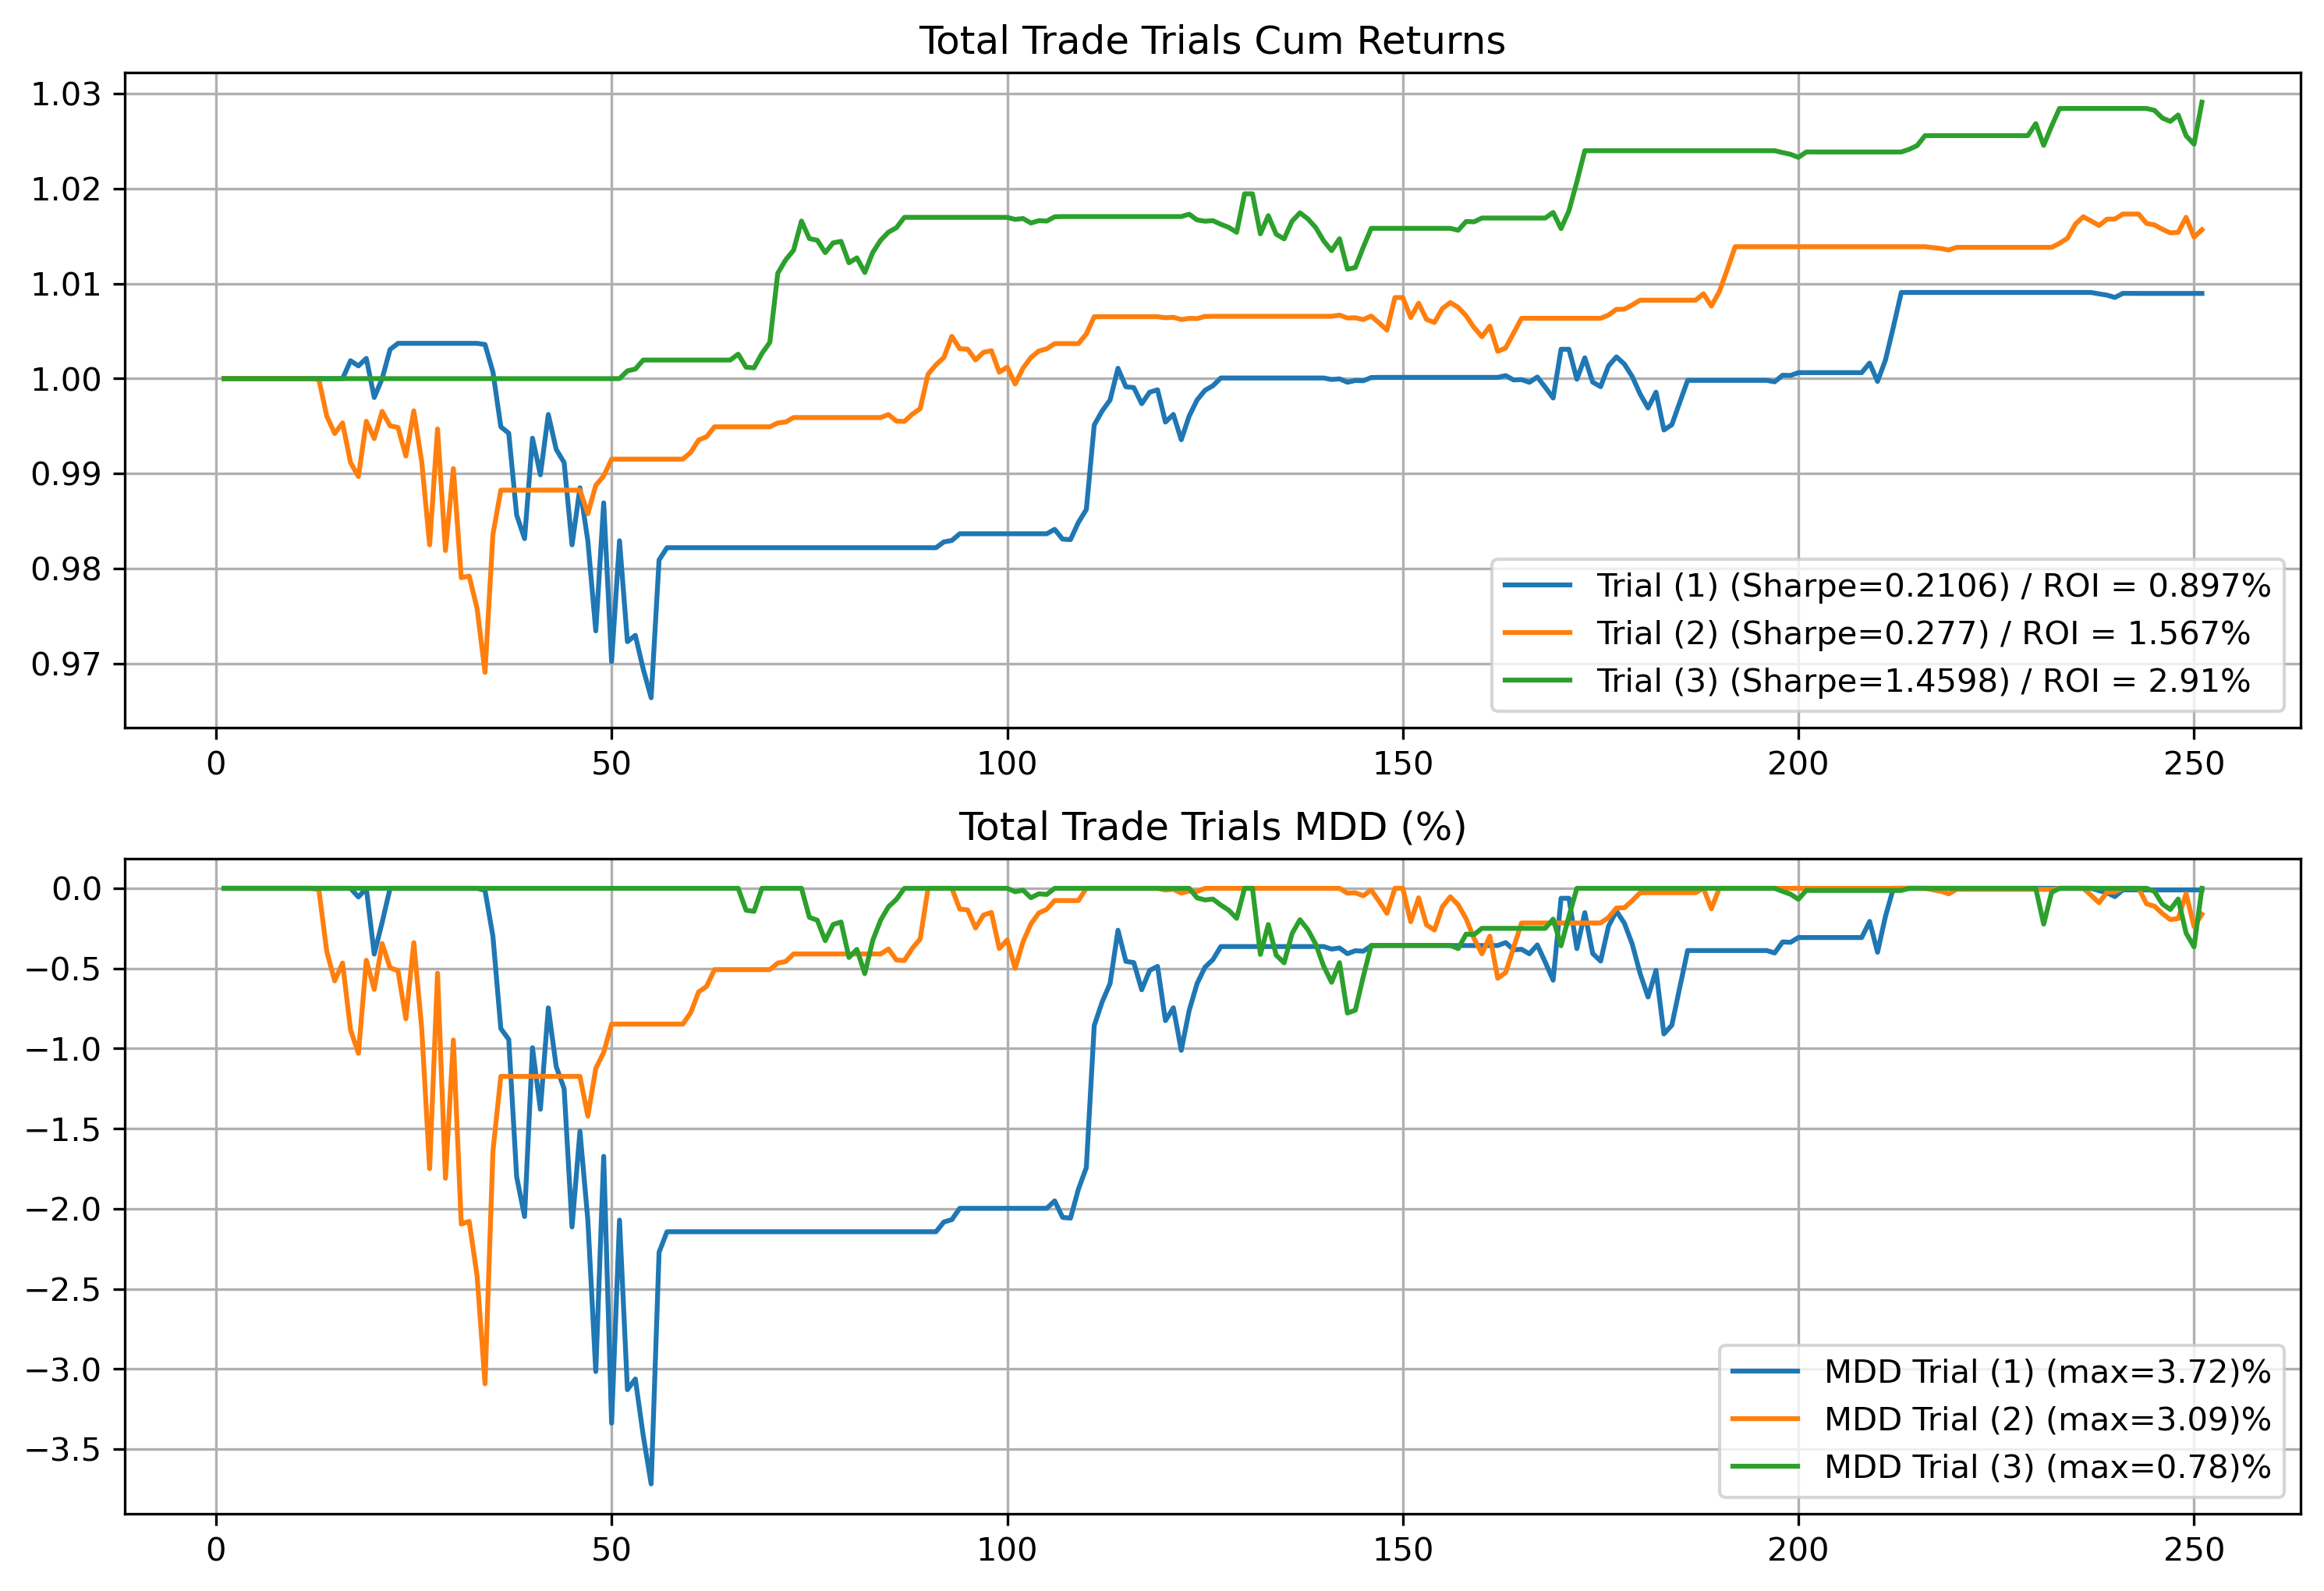

In [812]:
assemble = trial_port_df.dropna()
roi = np.round((assemble.iloc[-1,:] - 1) * 100, 3)

plt.figure(figsize=(12,8), dpi=300)
plt.subplot(2,1,1)
plt.title(f'Total Trade Trials Cum Returns')
plt.plot(assemble[0], alpha=1, label=f'Trial (1) (Sharpe={np.round(trial_sharpe_df[0], 4)}) / ROI = {roi[0]}%')
plt.plot(assemble[1], alpha=1, label=f'Trial (2) (Sharpe={np.round(trial_sharpe_df[1], 4)}) / ROI = {roi[1]}%')
plt.plot(assemble[2], alpha=1, label=f'Trial (3) (Sharpe={np.round(trial_sharpe_df[2], 4)}) / ROI = {roi[2]}%')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.title(f'Total Trade Trials MDD (%)')
plt.plot(get_mdd(assemble[0]), alpha=1, label=f'MDD Trial (1) (max={np.round(-min(get_mdd(assemble[0])), 2)})%')
plt.plot(get_mdd(assemble[1]), alpha=1, label=f'MDD Trial (2) (max={np.round(-min(get_mdd(assemble[1])), 2)})%')
plt.plot(get_mdd(assemble[2]), alpha=1, label=f'MDD Trial (3) (max={np.round(-min(get_mdd(assemble[2])), 2)})%')
#plt.fill_between(plot.index, get_mdd(plot[plot.columns[-1]]), color='pink', alpha=0.8)
plt.legend()
plt.grid()